In [33]:
! pip install xgboost

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score ,GridSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor , GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost
from xgboost import XGBRegressor
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Capstone Project.xlsx')

In [3]:
df 

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,270,55.06


In [4]:
def custom_summary(df):
    
    result = []
    for i in df.columns:
        
        statistics = OrderedDict({
            "Feature Name": i,
            'Count': df[i].count(),
            'Data type': df[i].dtype,
            'Min': round(df[i].min(),2),
            "Quartiles 1": round(df[i].quantile(.25),2),
            "Mean": round(df[i].mean(),2),
            "Median": round(df[i].quantile(.50),2),
            "Quartiles 3": round(df[i].quantile(.75),2),
            "Max": round(df[i].max(),2),
            "Var": round(df[i].var(),2),
            "Std": round(df[i].std(),2),
            'IQR': round(df[i].quantile(.75),2) - round(df[i].quantile(.25),2),
        })
        
        result.append(statistics)
        
        
        #checking for kurtosis

        if df[i].kurt() >= 1 :  #start kurt
            label = 'LeptoKurtic'
        elif df[i].kurt() <= -1 :
            label = 'Platykurtic'
        else:
            label = 'Mesokurtic'      #end kurt
        statistics['kurtosis comment'] = label
        
        #checking for skewness
        sk=df[i].skew()
        if sk<=-1:
            sk_v='Highle -ve skewed'
        elif sk>-1 and sk<-0.5:
            sk_v='Moderately -ve skewed'
        elif sk>=-0.5 and sk<=0.5:
            sk_v='Approx symmetric'
        elif sk>0.5 and sk<1:
            sk_v='Moderately +ve skewed'
        elif sk>=1:
            sk_v='Highle +ve skewed'
        statistics['skewness comment'] = sk_v
        
        
    result_df = pd.DataFrame(data = result)
        
    return(result_df)
        

In [5]:
custom_summary(df)

,Feature Name,Count,Data type,Min,Quartiles 1,Mean,Median,Quartiles 3,Max,Var,Std,IQR,kurtosis comment,skewness comment
0,cement,1030,float64,102.00,192.38,281.17,272.90,350.00,540.0,10921.58,104.51,157.62,Mesokurtic,Moderately +ve skewed
1,slag,1030,float64,0.00,0.00,73.90,22.00,142.95,359.4,7444.12,86.28,142.95,Mesokurtic,Moderately +ve skewed
2,ash,1030,float64,0.00,0.00,54.19,0.00,118.30,200.1,4095.62,64.00,118.30,Platykurtic,Moderately +ve skewed
3,water,1030,float64,121.80,164.90,181.57,185.00,192.00,247.0,456.00,21.35,27.10,Mesokurtic,Approx symmetric
4,superplastic,1030,float64,0.00,0.00,6.20,6.40,10.20,32.2,35.69,5.97,10.20,LeptoKurtic,Moderately +ve skewed
5,coarseagg,1030,float64,801.00,932.00,972.92,968.00,1029.40,1145.0,6045.68,77.75,97.40,Mesokurtic,Approx symmetric
6,fineagg,1030,float64,594.00,730.95,773.58,779.50,824.00,992.6,6428.19,80.18,93.05,Mesokurtic,Approx symmetric
7,age,1030,int64,1.00,7.00,45.66,28.00,56.00,365.0,3990.44,63.17,49.00,LeptoKurtic,Highle +ve skewed
8,strength,1030,float64,2.33,23.71,35.82,34.44,46.14,82.6,279.08,16.71,22.43,Mesokurtic,Approx symmetric


Analysis after looking at custom summary

the data has no null values
age is highly skewed thus require treatment
since max of age is 365 this is yearly data
ash till quartile 2 is 0, all data in q3 and q4
as most of the features are skewed and have outliers, it is very important to have outlier treatment


# Outlier treatment function

In [6]:
def outlier_treat(df, col, method = 'quartile', strategy = 'median'):
    
    
    data = df[col]
    median = data.median()
    mean = data.mean()

    if method == 'quartile':
        q1 = data.quantile(.25)
        q2 = data.quantile(.5)
        q3 = data.quantile(.75)
        iqr = q3 - q1
        upper_limit = q3 + 1.5 * iqr
        lower_limit = q1 - 1.5 * iqr
        
    elif method == 'stdev':
        std = data.std()
        upper_limit = mean + 2 * std
        lower_limit = mean - 2 * std
    else:
        print('invalid method')
      
    
    outliers = df.loc[(data<lower_limit)|(data>upper_limit),col]
    outlier_percentage = round((len(outliers)/len(data)) * 100,2)
     
    if len(outliers) == 0 :
        print(f'feature {col} does not have any outlier') 
        print('________________________________________')
    else:
        print(f'feature {col} has outliers')
        print(f'outlier percentage is {outlier_percentage}')
        print('________________________________________')
              
              
    if strategy == 'median':
        df.loc[(data<lower_limit)|(data>upper_limit),col] = median
    elif strategy == 'mean':
        df.loc[(data<lower_limit)|(data>upper_limit),col] = mean
    else:
        print('pass a correct strategy')
        print('________________________________________')
    
              
    return(df)

# implementing odt plots (outlier detection plot )


In [7]:
def odtplots(df,col):
    
    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
    
    #ploting the box plot
    
    sns.boxplot(df[col],ax=ax1,color='red')
    ax1.set_title('box plot for '+ col)
    ax1.set_xlabel('values')
    ax1.set_ylabel('box plot distribution')
    
    
    #ploting the histogram with outliers
    
    sns.distplot(df[col],ax=ax2,color='blue')
    ax2.set_title('Histogram with outlier for '+ col)
    ax2.set_xlabel('Values')
    ax2.set_ylabel('Distribution')
    
    
    # ploting the histogram without outlier
    
    y = outlier_treat(df,col) 
    sns.distplot(y[col],ax=ax3,color='green')
    ax3.set_title('Histogram without outlier for '+ col)
    ax3.set_xlabel('Values')
    ax3.set_ylabel('Distribution')
    
    
    plt.show()

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


feature cement does not have any outlier
________________________________________


C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


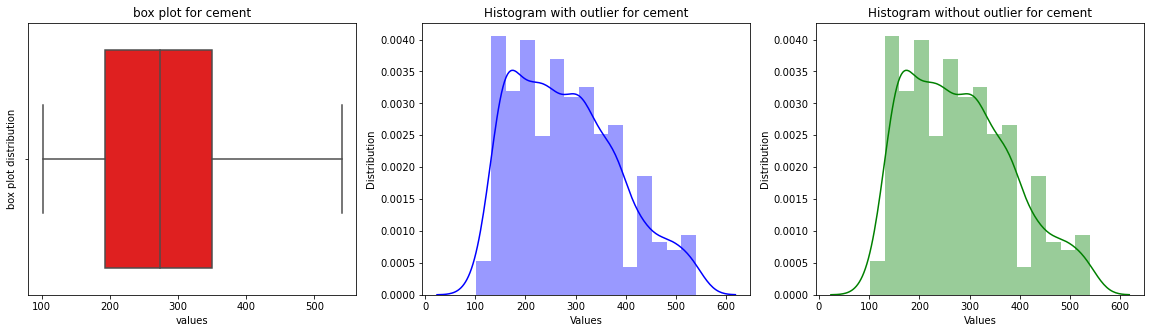

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


feature slag has outliers
outlier percentage is 0.19
________________________________________


C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


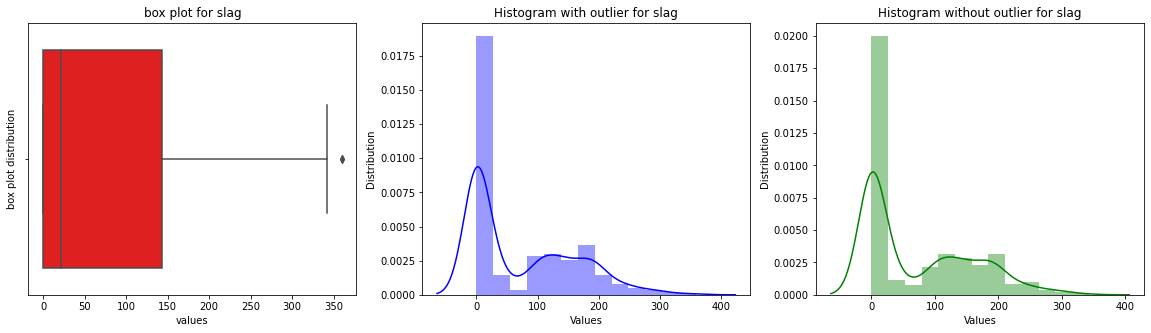

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  w

feature ash does not have any outlier
________________________________________


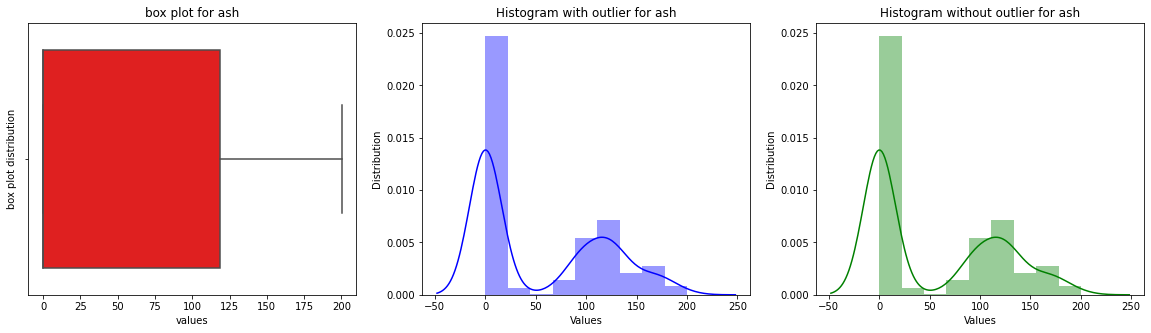

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


feature water has outliers
outlier percentage is 0.87
________________________________________


C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


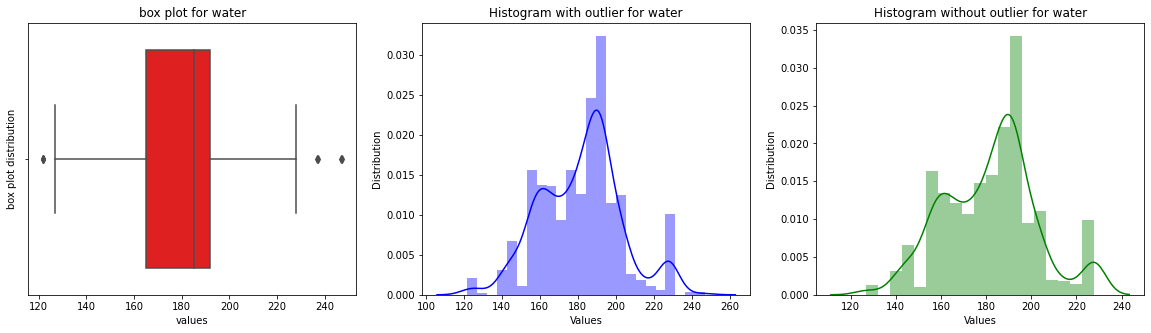

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


feature superplastic has outliers
outlier percentage is 0.97
________________________________________


C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


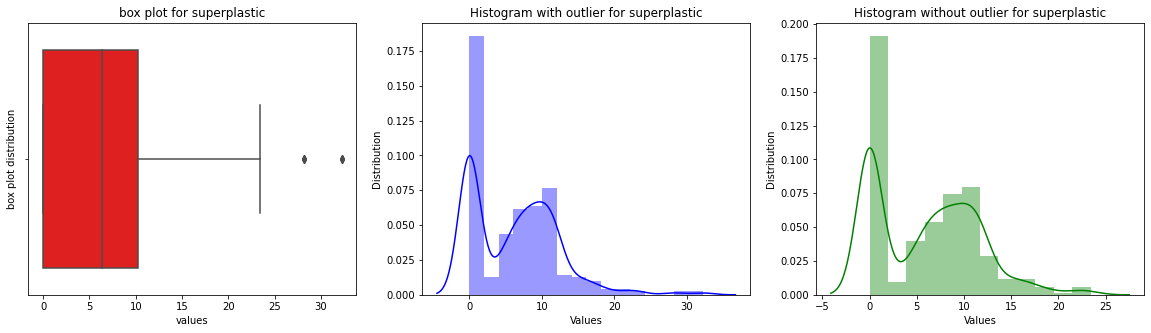

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  w

feature coarseagg does not have any outlier
________________________________________


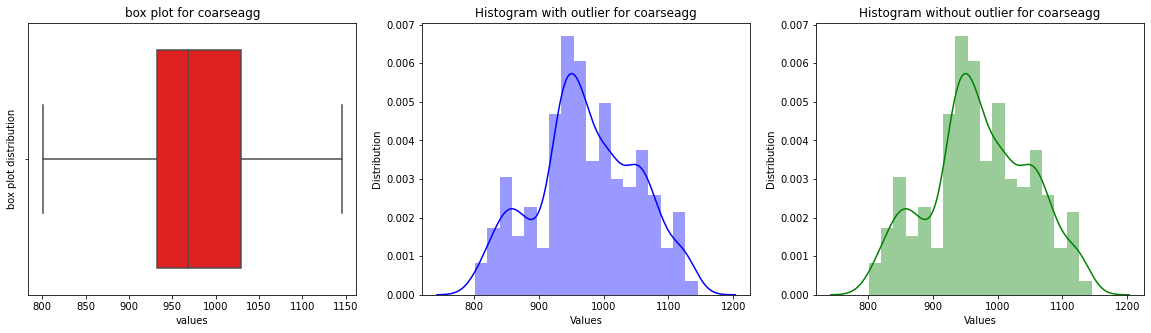

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


feature fineagg has outliers
outlier percentage is 0.49
________________________________________


C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


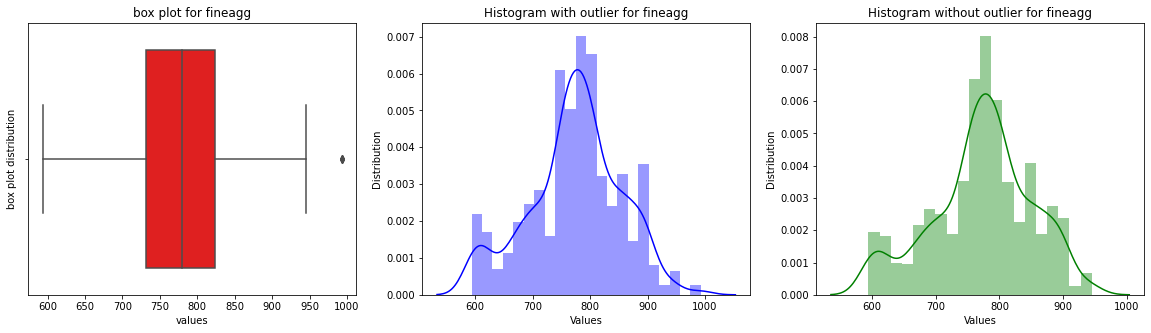

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  w

feature age has outliers
outlier percentage is 5.73
________________________________________


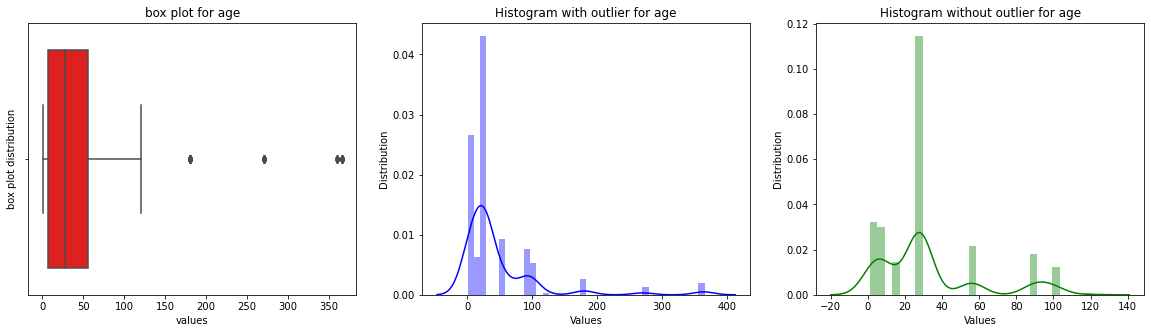

C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\aksha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  w

feature strength has outliers
outlier percentage is 0.39
________________________________________


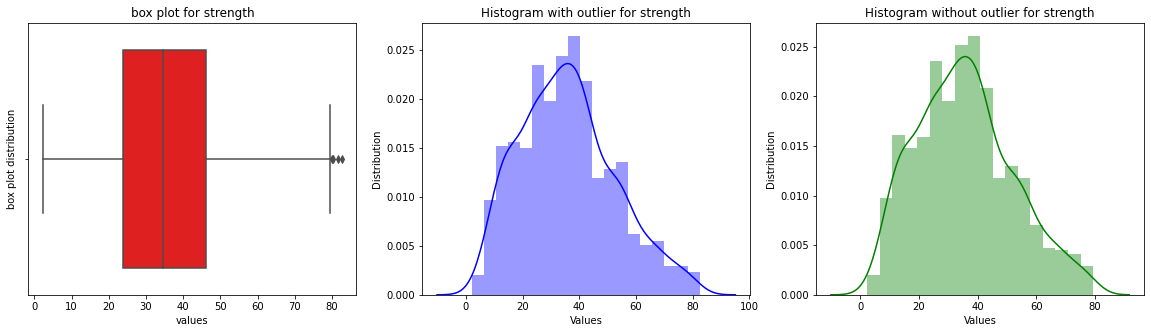

In [8]:
for col in df.columns :
    odtplots(df,col) 

# finding out correlation between variables and target variables

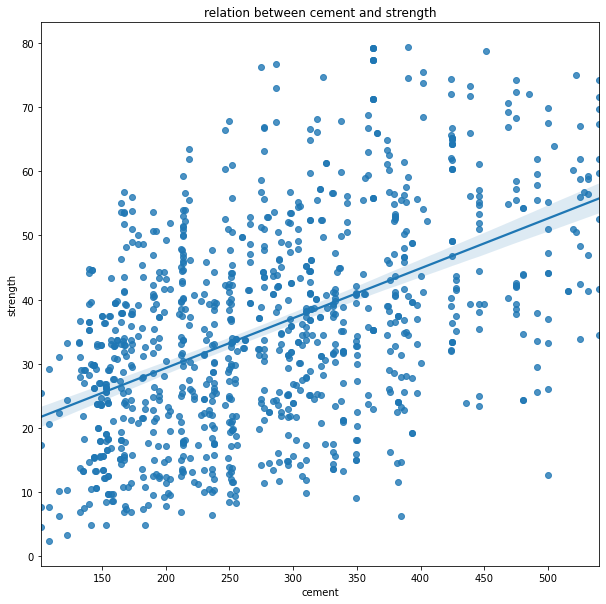

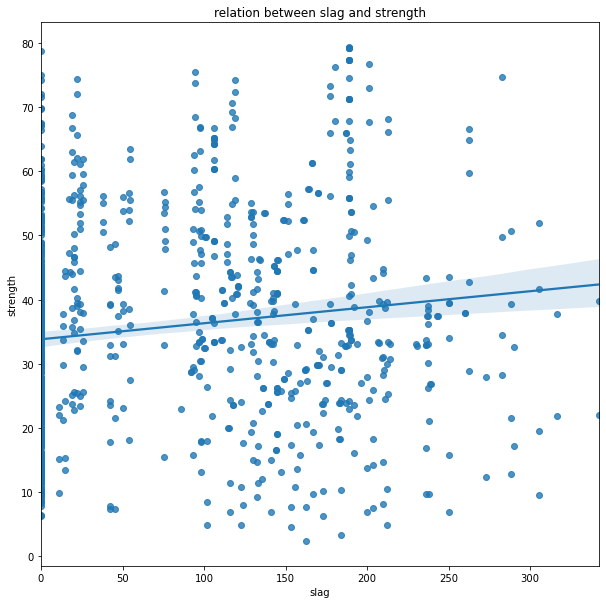

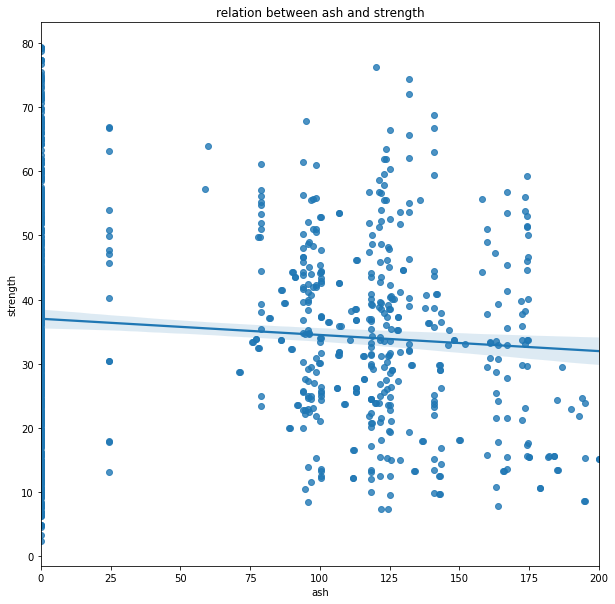

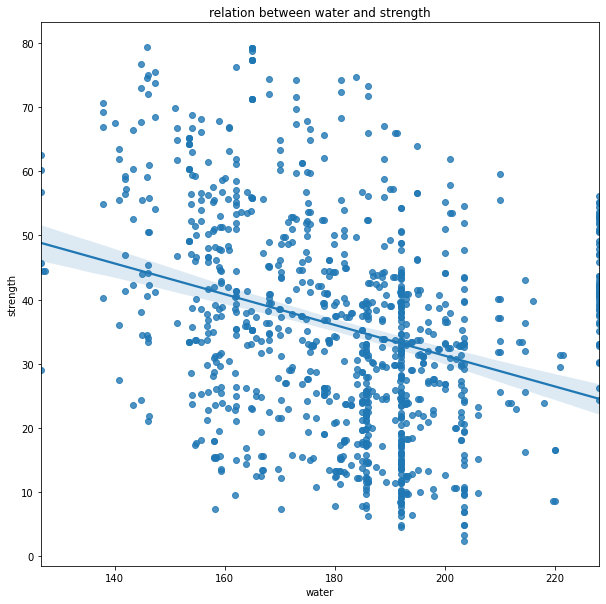

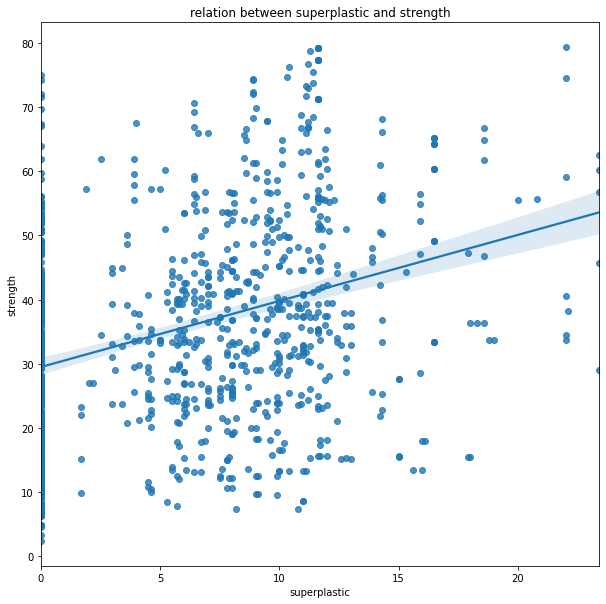

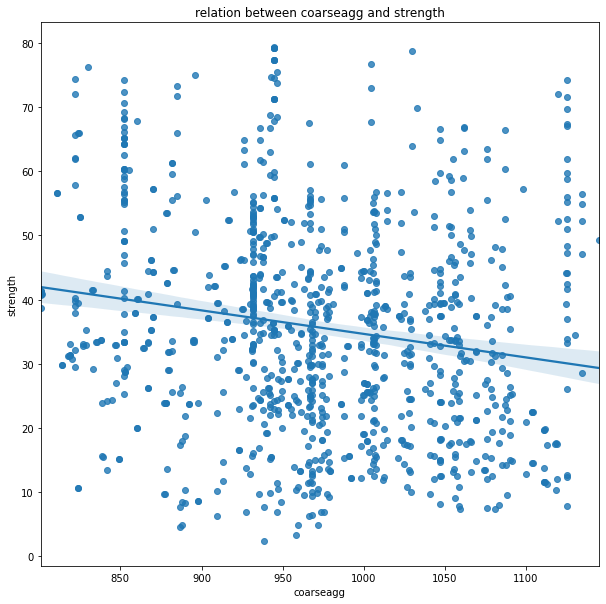

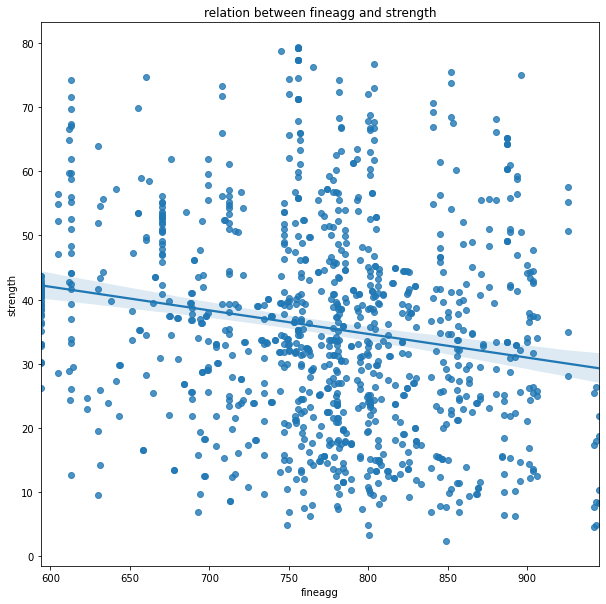

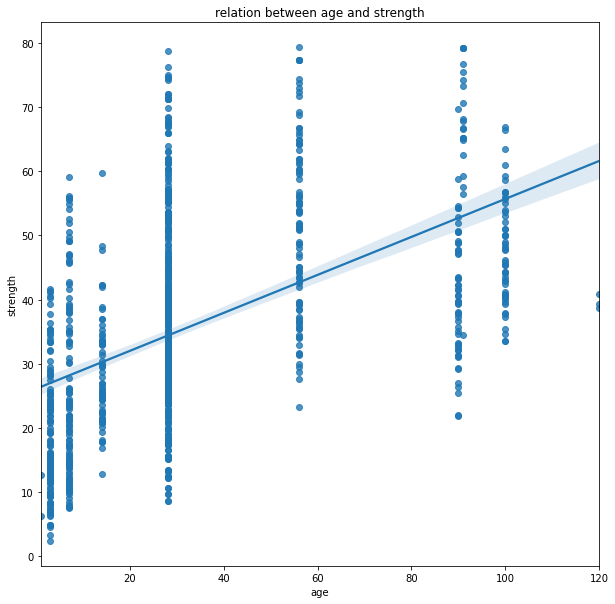

In [9]:
for col in df.columns :
    if col != 'strength' :
        f, ax = plt.subplots(figsize = (10,10))
        sns.regplot(x = df[col], y = df['strength']).set_title(f'relation between {col} and strength')

# find our correlation using correlation matrix

In [10]:
def corr_variables(df,target):
    ind_var = df.drop(target,axis=1).columns
    
    corr_result = []
    for col in ind_var:
        corr_result.append(df[target].corr(df[col]))
        
    result_df = pd.DataFrame([ind_var,corr_result],index = ['variables','correlation']).T.sort_values('correlation',ascending = False)
    
    return result_df

In [11]:
corr_variables(df,'strength')

,variables,correlation
7,age,0.499711
0,cement,0.493518
4,superplastic,0.342633
1,slag,0.129561
2,ash,-0.097973
5,coarseagg,-0.173234
6,fineagg,-0.176113
3,water,-0.300043


# checking  Multicolinearity

<AxesSubplot:>

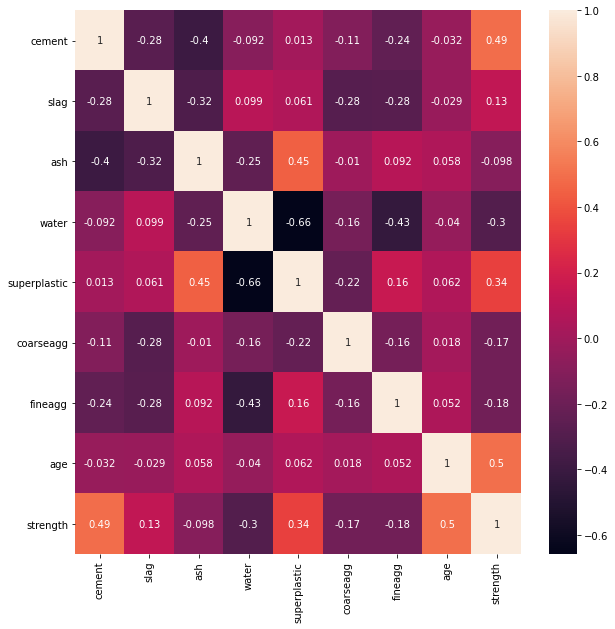

In [12]:
corr = df.corr()

fig = plt.subplots(figsize =(10,10))
sns.heatmap(corr,annot=True)

In [13]:
# analysis of Multicolinearity 
# super platic and ash are multicolinear (45%)
# ash and slag are are multicolinear (-32%)
# water and fine age are multicolinear (-43%)
# superplastic and water are multicolinear (-66%)

# varriance inflation Factor

In [14]:
# it is another method of checking multicolinearity
# vif = 1/(1-r2)
# if we get vif value morethan 5 then we say that multicolinearity exist 
# steps
# step 1 : regress every independent variable with all other and find out the r2 value
# step 2 : calculate vif with above formula


In [15]:
def vif(df,target):
    indep_var = df.drop(target,axis =1 )
    vif_df = pd.DataFrame()
    vif_df['vif_factor'] = [variance_inflation_factor(indep_var.values,i) for i in range(indep_var.shape[1])]
    vif_df['names'] = indep_var.columns
    
    return vif_df.sort_values('vif_factor',ascending=False)

In [16]:
vif(df,'strength')

,vif_factor,names
5,86.938582,coarseagg
3,81.963087,water
6,68.664404,fineagg
0,14.291158,cement
4,5.724145,superplastic
2,4.415840,ash
1,3.342314,slag
7,2.368372,age


# PCA

In [21]:
def apply_pca(x):
    col = []
    n_comp = len(x.columns)
    
    
    x =StandardScaler().fit_transform(x)
    
    
    for i in range(1,n_comp): # efining n component using for loop
        pca = PCA(n_components = i) # transforming x
        p_comp = pca.fit_transform(x) # doing cumiulative sum to find out total data capture
        evr = np.cumsum(pca.explained_variance_ratio_)
        if evr[i-1] > 0.9: # checking the data is more than 90 %
            n_components = i # condering i value to be n compent based on evr
            break
    
    print("The explined variance ratio is",evr)
    
    #creating data farme with PCA transfrom data
    
    for j in range(1,n_components + 1):
        col.append("pc_"+ str(j))
        
    result = pd.DataFrame(data = p_comp,columns=col)
        
        
    return(result)

In [22]:
pca_df = apply_pca(df.drop("strength",axis = 1))

The explined variance ratio is [0.27112429 0.44666571 0.60914114 0.73584634 0.85926016 0.97264602]


In [25]:
pca_df = pca_df.join(df[['strength']],how='left')

In [26]:
pca_df

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,strength
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110,29.89
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061,23.51
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045,29.22
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548,45.85
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228,18.29
...,...,...,...,...,...,...,...
1025,-1.743036,0.071059,-1.492203,0.045227,-0.449481,0.968953,13.29
1026,-1.079147,-0.572265,3.269799,-1.669125,-0.962953,0.002303,41.30
1027,-0.494143,1.276989,0.318398,-0.053272,-0.153787,0.751019,44.28
1028,2.688411,-0.236744,0.056551,-0.088955,0.105206,1.368321,55.06


In [27]:
vif(pca_df,'strength')

,vif_factor,names
4,1.0,pc_5
0,1.0,pc_1
2,1.0,pc_3
3,1.0,pc_4
5,1.0,pc_6
1,1.0,pc_2


In [28]:
def train_and_test_split(df,target,testSize=0.3):
    x = df.drop(target,axis = 1)
    y = df[[target]]
    
    return(train_test_split(x,y,test_size=testSize, random_state= 0))

In [29]:
def build_model(model_name, estimetor, data, target):
    x_train, x_test ,y_train, y_test = train_and_test_split(data,target)
    estimetor.fit(x_train,y_train)
    y_pred = estimetor.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2score = r2_score(y_test,y_pred)
    
    temp = [model_name,rmse,r2score]
    
    return(temp)


In [30]:
build_model("linear regression",LinearRegression(),pca_df,"strength")


['linear regression', 9.268894457764828, 0.6733375978100169]

In [36]:
def muliple_model(data, target):
    col_names = ["Model names","RMSE","R2Score"]
    
    result_df = pd.DataFrame(columns= col_names)
    
    result_df.loc[len(result_df)] = build_model("linear regression",LinearRegression(),data,target)
    
    result_df.loc[len(result_df)] = build_model("lasso regression",Lasso(),data,target)
    
    result_df.loc[len(result_df)] = build_model("Ridge",Ridge(),data,target)
    
    result_df.loc[len(result_df)] = build_model("Decision tree",DecisionTreeRegressor(),data,target)
    
    result_df.loc[len(result_df)] = build_model("KNN",KNeighborsRegressor(),data,target)
    
    result_df.loc[len(result_df)] = build_model("SVM",SVR(),data,target)

    result_df.loc[len(result_df)] = build_model("Random forest",RandomForestRegressor(),data,target)
    
    result_df.loc[len(result_df)] = build_model("Adaboost",AdaBoostRegressor(),data,target)
    
    result_df.loc[len(result_df)] = build_model("Gradient boost",GradientBoostingRegressor(),data,target)
    
    result_df.loc[len(result_df)] = build_model("XGBoost",XGBRegressor(),data,target)
    
    return(result_df.sort_values('R2Score',ascending=False))
    
    
    
   

In [37]:
muliple_model(pca_df,"strength")

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
<ipython-input-29-11caf0550dfd>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimetor.fit(x_train,y_train)
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,Model names,RMSE,R2Score
9,XGBoost,5.776115,0.873143
6,Random forest,6.096977,0.858658
8,Gradient boost,6.646475,0.832032
4,KNN,7.809566,0.768102
3,Decision tree,7.982984,0.757689
7,Adaboost,8.564286,0.721115
5,SVM,9.051841,0.688458
0,linear regression,9.268894,0.673338
2,Ridge,9.270519,0.673223
1,lasso regression,9.635047,0.647019


In [38]:
# the models that has to be taken futher are XGboost, Random Forest , Gradient Boost , KNN,Decision Tree,Adaboost

In [40]:
def cv_score(x,y,fold=10):
    
    # fitting cross validation for all models
    score_lr= cross_val_score(LinearRegression(),x,y,cv=fold)
    score_ls= cross_val_score(Lasso(),x,y,cv=fold)
    score_rd= cross_val_score(Ridge(),x,y,cv=fold)
    score_dt= cross_val_score(DecisionTreeRegressor(),x,y,cv=fold)
    score_knn= cross_val_score(KNeighborsRegressor(),x,y,cv=fold)
    score_svr= cross_val_score(SVR(),x,y,cv=fold)
    score_rf= cross_val_score(RandomForestRegressor(),x,y,cv=fold)
    score_Ada= cross_val_score(AdaBoostRegressor(),x,y,cv=fold)
    score_gr= cross_val_score(GradientBoostingRegressor(),x,y,cv=fold)
    score_xgb= cross_val_score(XGBRegressor(),x,y,cv=fold)
    
    model_names =['Linear Regression','Lasso Regression','Ridge Regression','Decission Tree','KNN',"SVR",'RAndon forest','Ada boost','Gradient boost','Xgboost']
    scores = [score_lr,score_ls,score_rd,score_dt,score_knn,score_svr,score_rf,score_Ada,score_gr,score_xgb]
    
    result= []
    
    for i in range(0,len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        estimator = model_names[i]
        temp = [estimator,score_std,score_mean]
        result.append(temp)
        
    results = pd.DataFrame(data= result,columns=['model_names','score_std','score_mean'])
    
    return results.sort_values('score_mean',ascending=False)
        

In [41]:
cv_score(pca_df.drop('strength',axis=1),pca_df[['strength']])

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

,model_names,score_std,score_mean
9,Xgboost,0.036061,0.873262
6,RAndon forest,0.031862,0.868210
8,Gradient boost,0.049863,0.828724
4,KNN,0.055730,0.767651
3,Decission Tree,0.059490,0.761751
7,Ada boost,0.035912,0.727322
5,SVR,0.042765,0.703117
2,Ridge Regression,0.059437,0.663935
0,Linear Regression,0.059476,0.663928
1,Lasso Regression,0.049887,0.649837


# Performing Hyper Parameter Tuning

In [64]:
def hyper_tuning(x,y,fold=10):
    
    param_ensemble= {'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],'n_estimators':[10,20,30,40,50,60,70,80,90,100]}
    param_knn = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]}
    param_rf = {'max_depth':[8,9,10,11,12],'n_estimators':[10,20,30,40,50,60,70,80,90,100]}
    param_dt = {'max_depth':[8,9,10,11,12]}
    
    
    tune_xg = GridSearchCV(XGBRegressor(),param_ensemble,cv=fold)
    tune_gr = GridSearchCV(GradientBoostingRegressor(),param_ensemble,cv=fold)
    tune_ad = GridSearchCV(AdaBoostRegressor(),param_ensemble,cv=fold)
    tune_rf = GridSearchCV(RandomForestRegressor(),param_rf,cv=fold)
    tune_kn = GridSearchCV(KNeighborsRegressor(),param_knn,cv=fold)
    tune_dt = GridSearchCV(DecisionTreeRegressor(),param_dt,cv=fold)
    
    tune_xg.fit(x,y)
    tune_gr.fit(x,y)
    tune_ad.fit(x,y)
    tune_rf.fit(x,y)
    tune_kn.fit(x,y)
    tune_dt.fit(x,y)
    
    tune=[tune_xg,tune_gr,tune_ad,tune_rf,tune_kn,tune_dt]
    models=['XGBoost','Gradient Boost','Ada Boosting','Random Forest','KNN','Decision Tree']
    
    for i in range(0,len(tune)):
        print('model',models[i])
        print('Best parameters',tune[i].best_params_)
    

In [65]:
hyper_tuning(pca_df.drop('strength',axis=1),pca_df[['strength']])

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

model XGBoost
Best parameters {'learning_rate': 0.3, 'n_estimators': 100}
model Gradient Boost
Best parameters {'learning_rate': 0.3, 'n_estimators': 100}
model Ada Boosting
Best parameters {'learning_rate': 0.8, 'n_estimators': 60}
model Random Forest
Best parameters {'max_depth': 12, 'n_estimators': 100}
model KNN
Best parameters {'n_neighbors': 4}
model Decision Tree
Best parameters {'max_depth': 10}


In [68]:
def cv_score_tune(x,y,fold=10):
    
    # fitting cross validation for all models
    score_dt= cross_val_score(DecisionTreeRegressor(max_depth= 10),x,y,cv=fold)
    score_knn= cross_val_score(KNeighborsRegressor(n_neighbors= 4),x,y,cv=fold)
    score_rf= cross_val_score(RandomForestRegressor(max_depth = 12, n_estimators= 100),x,y,cv=fold)
    score_Ada= cross_val_score(AdaBoostRegressor(learning_rate=0.8, n_estimators=60),x,y,cv=fold)
    score_gr= cross_val_score(GradientBoostingRegressor(learning_rate=0.3, n_estimators=100),x,y,cv=fold)
    score_xgb= cross_val_score(XGBRegressor(learning_rate=0.3, n_estimators=100),x,y,cv=fold)
    
    model_names =['Decission Tree','KNN','Randon forest','Ada boost','Gradient boost','Xgboost']
    scores = [score_dt,score_knn,score_rf,score_Ada,score_gr,score_xgb]
    
    result= []
    
    for i in range(0,len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        estimator = model_names[i]
        temp = [estimator,score_std,score_mean]
        result.append(temp)
        
    results = pd.DataFrame(data= result,columns=['model_names','score_std','score_mean'])
    
    return results.sort_values('score_mean',ascending=False)
        

In [69]:
cv_score_tune(pca_df.drop('strength',axis=1),pca_df[['strength']])

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

,model_names,score_std,score_mean
5,Xgboost,0.036061,0.873262
2,Randon forest,0.033691,0.864529
4,Gradient boost,0.049568,0.856539
0,Decission Tree,0.046954,0.771935
1,KNN,0.054508,0.771113
3,Ada boost,0.036085,0.729722


# Learning curve analysis

In [80]:
def learning_curve_analysis(model_name,estimator,x,y):
    
    
    train_size,train_score,test_score = learning_curve(estimator,X= x ,y= y,cv=10)
    train_score_mean = np.mean(train_score,axis = 1)
    test_score_mean = np.mean(test_score,axis = 1)
    
    
    plt.plot(train_size,train_score_mean,color = 'r')
    plt.plot(train_size,test_score_mean,color ='g')
    plt.xlabel('Samples')
    plt.ylabel('Score')
    plt.title('Learning Curve for '+ model_name)
    plt.legend(['train_score','test_score'])
    
    
    

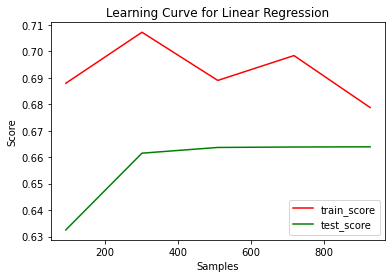

In [81]:
learning_curve_analysis('Linear Regression',LinearRegression(),pca_df.drop('strength',axis=1),pca_df[['strength']])

C:\Users\aksha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\aksha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y wa

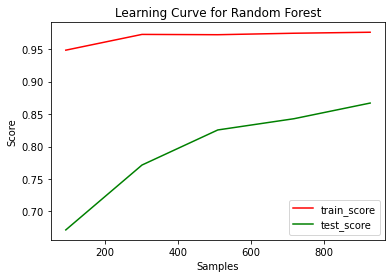

In [82]:
learning_curve_analysis('Random Forest',RandomForestRegressor(),pca_df.drop('strength',axis=1),pca_df[['strength']])

In [84]:
# applaying clustering to see if accuracy is improving

In [85]:
from sklearn.cluster import KMeans

In [86]:
x = df.drop('strength',axis =1)
y = df[['strength']]

In [87]:
labels = KMeans(n_clusters=2,random_state=100).fit_predict(x)

In [99]:
labels

array([0, 0, 0, ..., 0, 1, 1])

In [100]:
len(labels)

1030

In [88]:
x.columns

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age'],
      dtype='object')

<AxesSubplot:xlabel='age', ylabel='strength'>

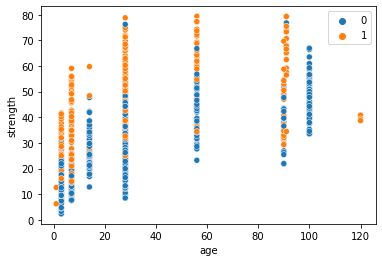

In [98]:
sns.scatterplot(x.age,y.strength,hue=labels)

In [90]:
# cement is having cluster with strength

In [101]:
clusterdf =df.join(pd.DataFrame(labels,columns=['labels']),how = 'left')

In [109]:
clusterdf

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,labels
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,1
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,0
...,...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29,0
1026,531.3,0.0,0.0,141.8,6.4,852.1,893.7,3,41.30,1
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06,1


In [103]:
cv_score(clusterdf.drop('strength',axis=1),clusterdf[['strength']])

,model_names,score_std,score_mean
9,Xgboost,0.046856,0.899436
6,RAndon forest,0.037073,0.885357
8,Gradient boost,0.044860,0.875369
3,Decission Tree,0.046450,0.835901
7,Ada boost,0.033368,0.741490
1,Lasso Regression,0.062488,0.686684
2,Ridge Regression,0.062316,0.686647
0,Linear Regression,0.062314,0.686640
4,KNN,0.086221,0.668430
5,SVR,0.038833,0.223931


In [116]:
x = clusterdf.drop('strength',axis=1)
y = clusterdf[['strength']]

In [104]:
# Feature importance using XGBoost

In [120]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2)

In [121]:
xgb = XGBRegressor()

In [122]:
xgb.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

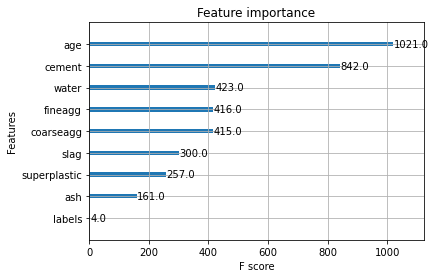

In [123]:
xgboost.plot_importance(xgb)

In [124]:
x = clusterdf[['age','cement','water','fineagg','coarseagg','slag']]
y = clusterdf[['strength']]

In [125]:
cv_score(x,y)

,model_names,score_std,score_mean
9,Xgboost,0.046844,0.897331
6,RAndon forest,0.035204,0.885296
8,Gradient boost,0.045512,0.875773
3,Decission Tree,0.054647,0.822514
7,Ada boost,0.039231,0.731626
1,Lasso Regression,0.061546,0.679548
2,Ridge Regression,0.061858,0.679539
0,Linear Regression,0.061858,0.679539
4,KNN,0.088739,0.656448
5,SVR,0.037619,0.261459
